## Hillslope diffusion model for Eightmile Lake

### Inputs: Eightmile Lake DEM
### Components: ExponentialWeatherer, DepthDependentDiffuser
### Outputs: Soil flux map

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import rasterio as rio
from rasterio.enums import Resampling

from landlab import RasterModelGrid
from landlab.plot import imshow_grid
from landlab.components import ExponentialWeatherer, DepthDependentDiffuser

/home/egp/.virtualenvs/landlab/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### Step 1) Resample DEM to 30m

In [2]:
current = 2 # meters per pixel
target = 30 # meters per pixel
scale = current / target

with rio.open('./gis/projects/dem/eightmile-lake-watershed-dem-filled.tif') as src:

    # resample data to target shape
    data = src.read(
        out_shape = (
            src.count,
            int(src.height * scale),
            int(src.width * scale)
        ),
        resampling = Resampling.bilinear
    )

    # scale image transform
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )
    
dem = data[0]

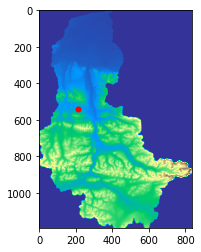

In [3]:
dem = np.flip(np.transpose(data[0]), 0)

plt.imshow(dem, cmap = 'terrain')
plt.scatter(210, 540, s = 25, color = 'red')
plt.show()

### Step 2) Set up model grid and initial conditions

In [4]:
grid = RasterModelGrid((dem.shape[0], dem.shape[1]), target)

In [5]:
grid.add_field('topographic__elevation', np.flip(dem, 0), at = 'node', units = 'm', copy = True, clobber = True)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [6]:
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__elevation'], 0)

In [7]:
initial_soil = 1 # meters
grid.add_field('bedrock__elevation', grid.at_node['topographic__elevation'] - initial_soil, at = 'node', clobber = True)
grid.add_field('soil__depth', np.full_like(dem, initial_soil), at = 'node', clobber = True)
grid.at_node['soil__depth'] = grid.at_node['topographic__elevation'] - grid.at_node['bedrock__elevation']
grid.add_zeros('soil_production__rate', at = 'node')

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

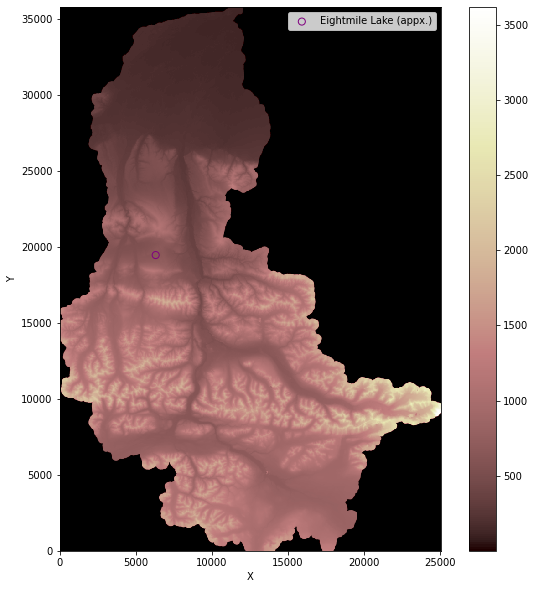

In [8]:
fig, ax = plt.subplots(figsize = (10, 10))
imshow_grid(grid, 'topographic__elevation')
plt.scatter(6300, 19440, s = 50, color = 'purple', facecolors = 'none', label = 'Eightmile Lake (appx.)')
plt.legend(loc = 'upper right')
plt.show()

In [9]:
# Convert fields from float32 to float
# TODO ask Mark what's going on with the components here

grid.at_node['topographic__elevation'] = grid.at_node['topographic__elevation'].astype(float)
grid.at_node['bedrock__elevation'] = grid.at_node['bedrock__elevation'].astype(float)
grid.at_node['soil__depth'] = grid.at_node['soil__depth'].astype(float)

### Step 3) Initialize model components

In [10]:
DD = DepthDependentDiffuser(grid, linear_diffusivity = 0.01)
EW = ExponentialWeatherer(grid, soil_production__maximum_rate = 0.1)

In [11]:
nt = 1000
dt = 1000
count = 0
initial_soil = grid.at_node['soil__depth'][:].copy()
initial_topo = grid.at_node['topographic__elevation'][:].copy()

for i in range(nt):
    EW.calc_soil_prod_rate()
    DD.run_one_step(dt)
    
    count += 1
    if count % (nt / 10) == 0:
        print('Completed ' + str(count) + ' time steps.')
    
soil_dz = grid.at_node['soil__depth'] - initial_soil
topo_dz = grid.at_node['topographic__elevation'] - initial_topo

Completed 100 time steps.
Completed 200 time steps.
Completed 300 time steps.
Completed 400 time steps.
Completed 500 time steps.
Completed 600 time steps.
Completed 700 time steps.
Completed 800 time steps.
Completed 900 time steps.
Completed 1000 time steps.


In [36]:
grid.at_node.keys()

['soil_production__rate',
 'topographic__elevation',
 'bedrock__elevation',
 'soil__depth']

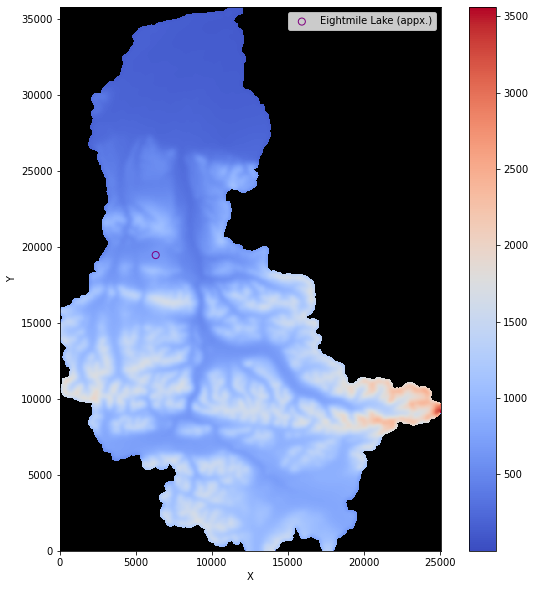

In [38]:
fig, ax = plt.subplots(figsize = (10, 10))
imshow_grid(grid, 'topographic__elevation', cmap = 'coolwarm')
plt.scatter(6300, 19440, s = 50, color = 'purple', facecolors = 'none', label = 'Eightmile Lake (appx.)')
plt.legend(loc = 'upper right')
plt.show()

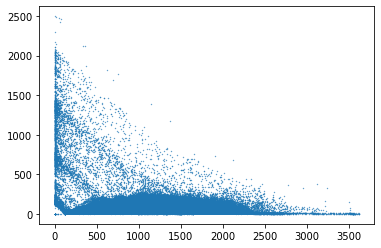

In [40]:
plt.scatter(initial_topo, grid.at_node['soil__depth'], s = 0.1)
plt.show()